

# Exercise Notebook: Liver Lesion Segmentation with 3Dircadb Dataset



## Dataset Preparation
Before starting the exercises, follow these steps:
1. Download the 3Dircadb dataset
2. Load the first subject's data
3. Extract slices 60, 80, 111, and 117 for our exercises

In [2]:
import os
import SimpleITK as sitk
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def load_dicom_images_from_folder(folder_path):
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    dicom_files.sort(key=lambda f: int(''.join(filter(str.isdigit, os.path.basename(f)))))
    return dicom_files

def read_dicom_series(dicom_files):
    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def convert_to_volume(dicom_files):
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(dicom_files)
    image = reader.Execute()
    return image

def load_volume(folder_path):
    dicom_files = load_dicom_images_from_folder(folder_path)
    slices = read_dicom_series(dicom_files)
    volume = convert_to_volume(dicom_files)
    return sitk.GetArrayFromImage(volume)

def get_tumor_folders(main_directory):
    tumor_folders = [os.path.join(main_directory, folder) for folder in os.listdir(main_directory)]
    return tumor_folders

def sum_tumor_volumes(tumor_volumes):
    combined_array = sitk.GetArrayFromImage(tumor_volumes[0])
    for volume in tumor_volumes[1:]:
        volume_array = sitk.GetArrayFromImage(volume)
        combined_array += volume_array
        combined_volume = sitk.GetImageFromArray(combined_array)
        combined_volume.CopyInformation(tumor_volumes[0])

    return combined_volume

def load_and_sum_tumors(main_directory):
    tumor_folders = get_tumor_folders(main_directory)
    tumor_volumes = []

    for folder in tumor_folders:
        dicom_files = load_dicom_images_from_folder(folder)
        tumor_volume = convert_to_volume(dicom_files)
        tumor_volumes.append(tumor_volume)

    combined_volume = sum_tumor_volumes(tumor_volumes)
    return sitk.GetArrayFromImage(combined_volume)




ct_volume = load_volume(r"D:\CodePro\VsCodePythonPro\MachinelearningClass\EX7\3Dircadb1.1\PATIENT_DICOM")
liver_mask_volume = load_volume(r"D:\CodePro\VsCodePythonPro\MachinelearningClass\EX7\3Dircadb1.1\MASKS_DICOM\liver")
tumors_mask_volume = load_and_sum_tumors(r"D:\CodePro\VsCodePythonPro\MachinelearningClass\EX7\3Dircadb1.1\MASKS_DICOM\tumors_mask_volume")

print(f"Combined volume size: {tumors_mask_volume.shape}")

Combined volume size: (129, 512, 512)


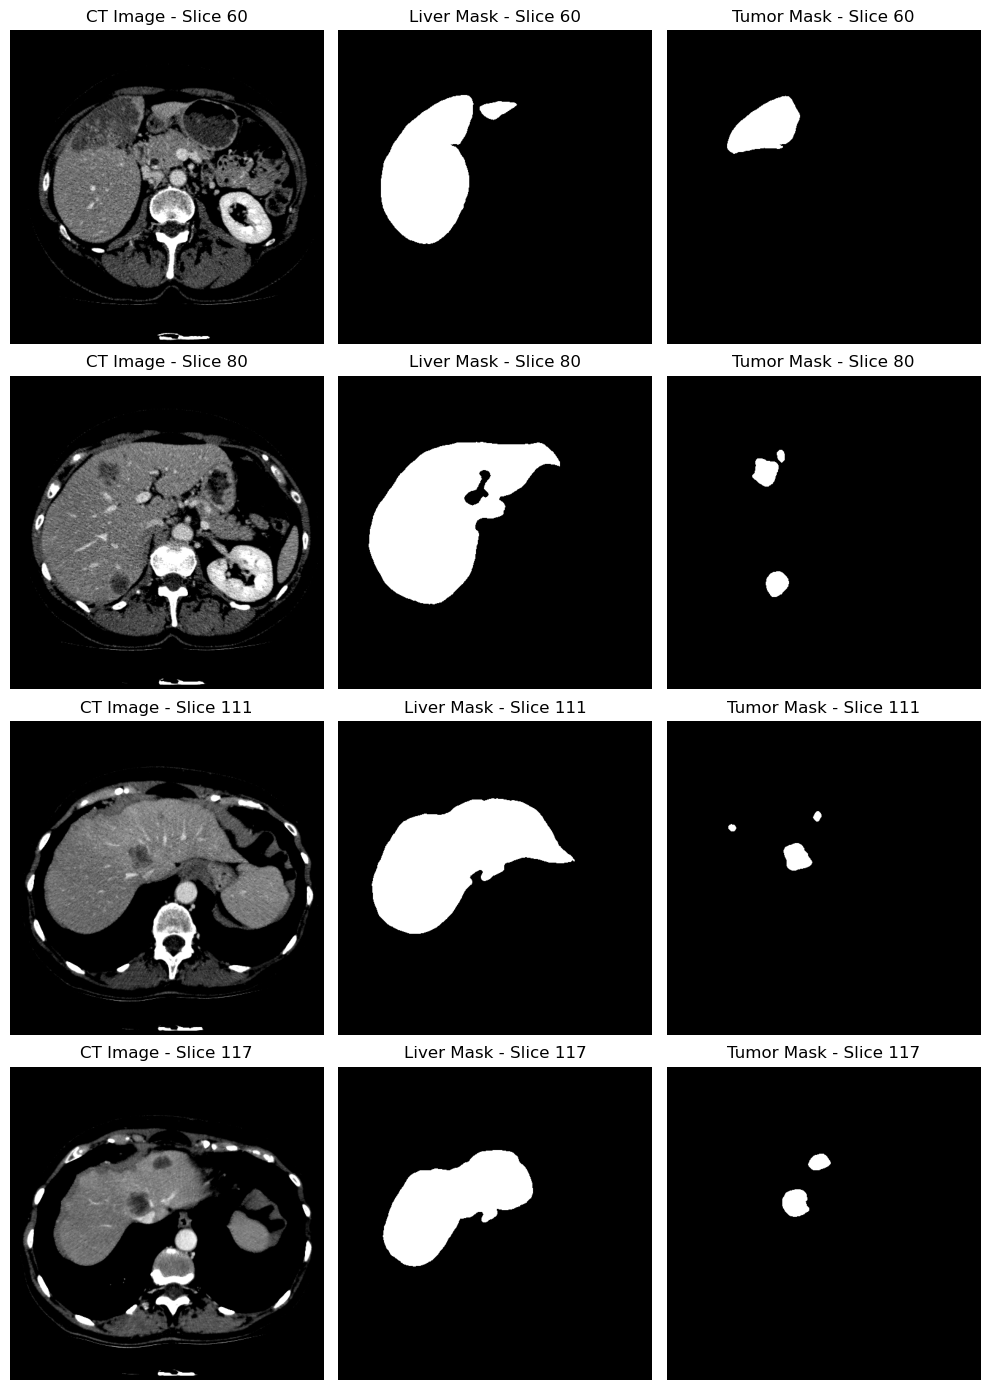

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,14))

plt.subplot(4, 3, 1)
plt.imshow(ct_volume[60, :, :], cmap='gray')
plt.title("CT Image - Slice 60")
plt.axis("off")

plt.subplot(4, 3, 2)
plt.imshow(liver_mask_volume[60, :, :], cmap='gray')
plt.title("Liver Mask - Slice 60")
plt.axis("off")

plt.subplot(4, 3, 3)
plt.imshow(tumors_mask_volume[60, :, :], cmap='gray')
plt.title("Tumor Mask - Slice 60")
plt.axis("off")

plt.subplot(4, 3, 4)
plt.imshow(ct_volume[80, :, :], cmap='gray')
plt.title("CT Image - Slice 80")
plt.axis("off")

plt.subplot(4, 3, 5)
plt.imshow(liver_mask_volume[80, :, :], cmap='gray')
plt.title("Liver Mask - Slice 80")
plt.axis("off")

plt.subplot(4, 3, 6)
plt.imshow(tumors_mask_volume[80, :, :], cmap='gray')
plt.title("Tumor Mask - Slice 80")
plt.axis("off")

plt.subplot(4, 3, 7)
plt.imshow(ct_volume[111, :, :], cmap='gray')
plt.title("CT Image - Slice 111")
plt.axis("off")

plt.subplot(4, 3, 8)
plt.imshow(liver_mask_volume[111, :, :], cmap='gray')
plt.title("Liver Mask - Slice 111")
plt.axis("off")

plt.subplot(4, 3, 9)
plt.imshow(tumors_mask_volume[111, :, :], cmap='gray')
plt.title("Tumor Mask - Slice 111")
plt.axis("off")

plt.subplot(4, 3, 10)
plt.imshow(ct_volume[117, :, :], cmap='gray')
plt.title("CT Image - Slice 117")
plt.axis("off")

plt.subplot(4, 3, 11)
plt.imshow(liver_mask_volume[117, :, :], cmap='gray')
plt.title("Liver Mask - Slice 117")
plt.axis("off")

plt.subplot(4, 3, 12)
plt.imshow(tumors_mask_volume[117, :, :], cmap='gray')
plt.title("Tumor Mask - Slice 117")
plt.axis("off")

plt.tight_layout()
plt.show()

## Exercise 1: Implement KMeans
Implement the KMeans algorithm for the following slices from the 3Dircadb dataset: **80**, **111**, and **117**. Compare the results visually and quantitatively to evaluate the segmentation performance.

In [4]:
ct_volume = np.clip(ct_volume, 0, 255)
liver_mask_volume = liver_mask_volume / 255
tumors_mask_volume = tumors_mask_volume / 255

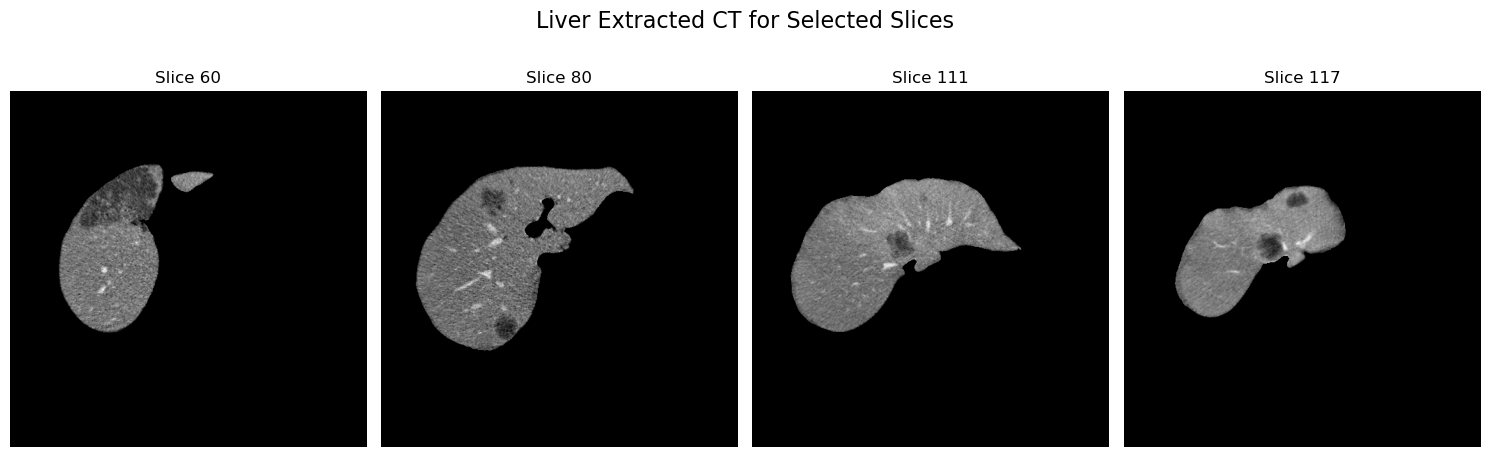

In [8]:
slices = [60, 80, 111, 117]

fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))

for idx, slice_idx in enumerate(slices):
    ct = ct_volume[slice_idx, :, :]
    liver_mask = liver_mask_volume[slice_idx, :, :]

    liver_extracted_ct = ct * liver_mask

    axes[idx].imshow(liver_extracted_ct, cmap='gray')
    axes[idx].set_title(f"Slice {slice_idx}")
    axes[idx].axis("off")

plt.suptitle("Liver Extracted CT for Selected Slices", fontsize=16)

plt.tight_layout()
plt.show()


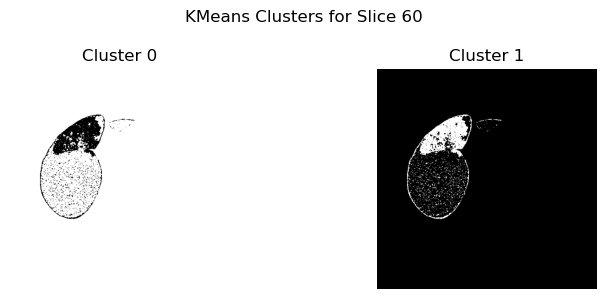

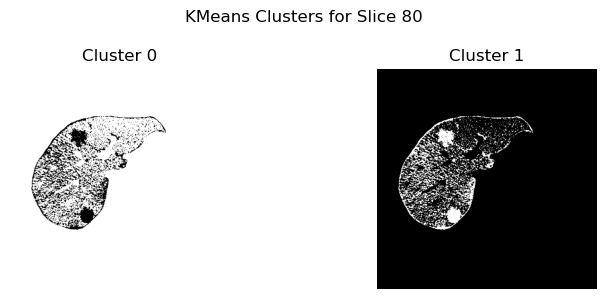

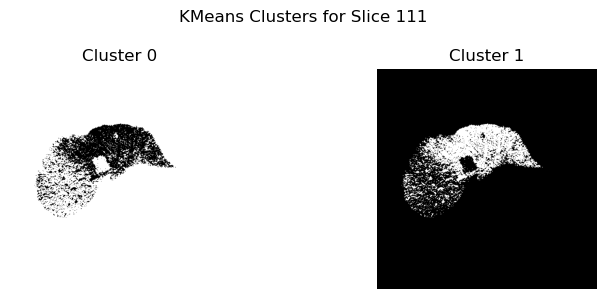

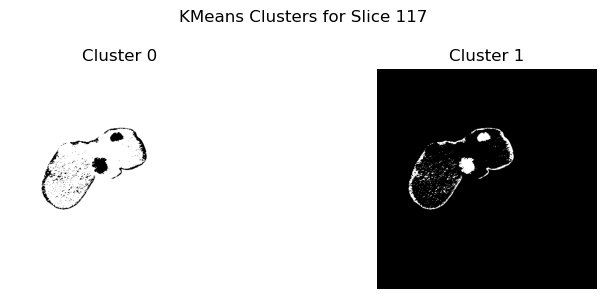

In [24]:
from sklearn.cluster import KMeans

slices = [60, 80, 111, 117]

for slice_idx in slices:
    ct = ct_volume[slice_idx, :, :]
    liver_mask = liver_mask_volume[slice_idx, :, :]
    
    liver_extracted_ct = ct * liver_mask

    liver_pixels = liver_extracted_ct[liver_mask > 0]
    liver_pixels = liver_pixels.reshape(-1, 1)  # Reshape for scaling

    scaler = StandardScaler()
    liver_pixels_scaled = scaler.fit_transform(liver_pixels)

    k = 2
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(liver_pixels_scaled)

    labels = kmeans.predict(liver_pixels_scaled)

    clustered_image = np.zeros(liver_extracted_ct.shape, dtype=int)
    clustered_image[liver_mask > 0] = labels  # Assign labels to the pixels based on mask

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    plt.figure(figsize=(8, 3))
    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i + 1)
        mask = clustered_image == i 
        plt.imshow(mask, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')

    plt.suptitle(f'KMeans Clusters for Slice {slice_idx}')
    plt.tight_layout()
    plt.show()



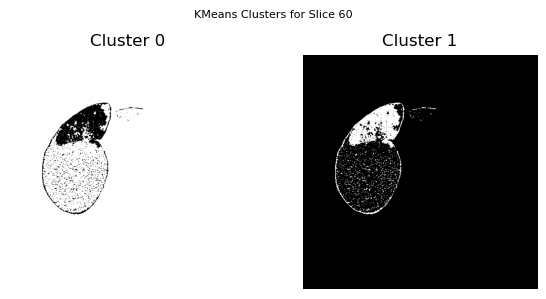

Evaluating silhouette scores for Slice 60:
k: 2  , Silhouette Score: 0.619
k: 3  , Silhouette Score: 0.536
k: 4  , Silhouette Score: 0.527
k: 5  , Silhouette Score: 0.511
k: 6  , Silhouette Score: 0.516
k: 7  , Silhouette Score: 0.520
k: 8  , Silhouette Score: 0.523
k: 9  , Silhouette Score: 0.521


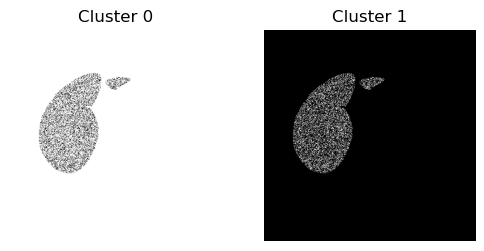

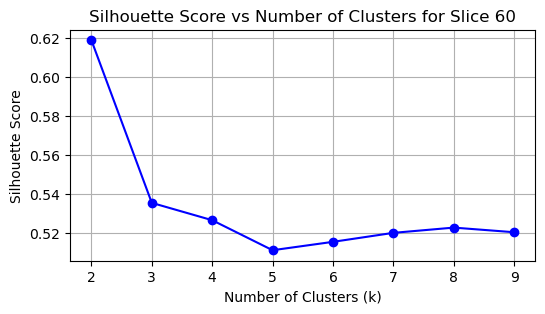

Best number of Clusters (K) for Slice 60 based on silhouette score: 2
Best silhouette score for Slice 60: 0.619
Cluster 1 for Slice 60 has the minimum number of pixels: 8317


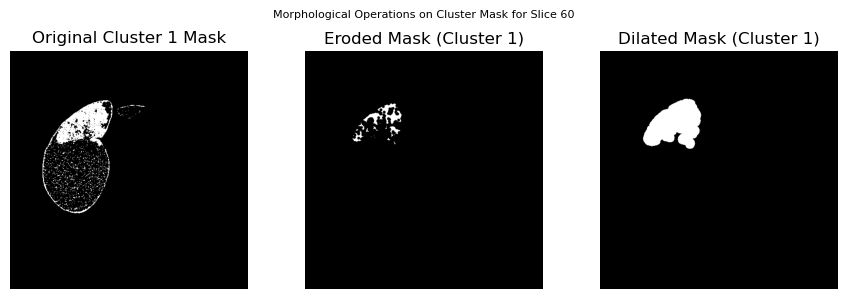

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 60:
Intersection over Union (IoU): 0.7747
Dice Coefficient: 0.8730


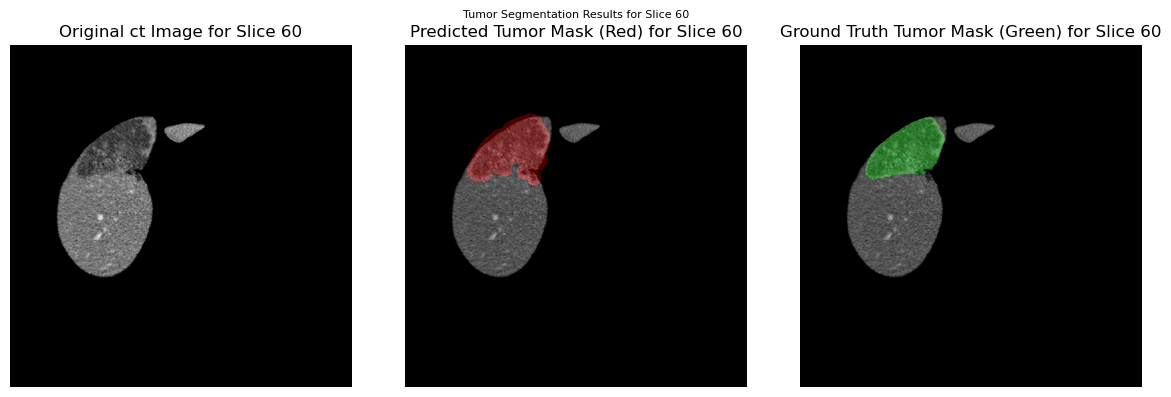

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 60:
Intersection over Union (IoU): 0.8747
Dice Coefficient: 0.9332


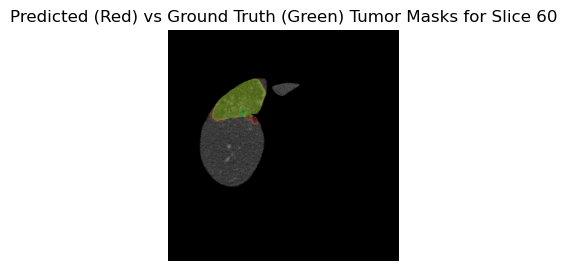


_________________________________________next_________________________________________



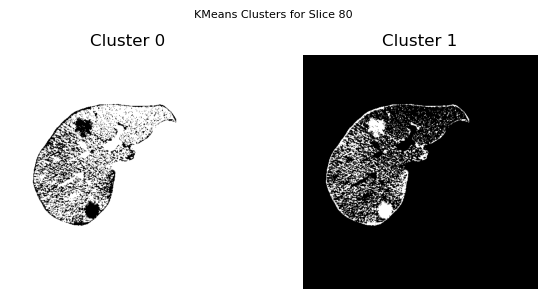

Evaluating silhouette scores for Slice 80:
k: 2  , Silhouette Score: 0.505
k: 3  , Silhouette Score: 0.522
k: 4  , Silhouette Score: 0.523
k: 5  , Silhouette Score: 0.518
k: 6  , Silhouette Score: 0.519
k: 7  , Silhouette Score: 0.522
k: 8  , Silhouette Score: 0.521
k: 9  , Silhouette Score: 0.520


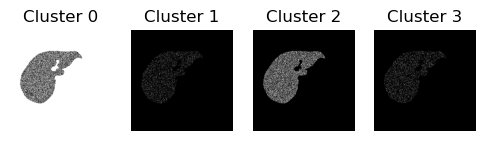

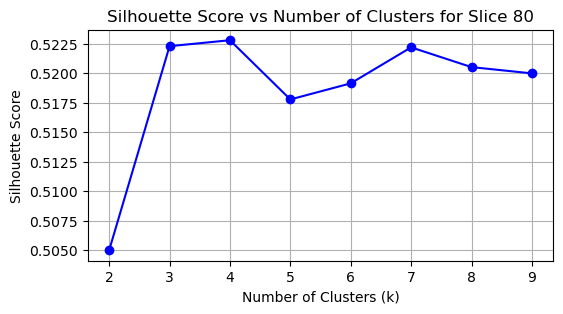

Best number of Clusters (K) for Slice 80 based on silhouette score: 4
Best silhouette score for Slice 80: 0.523
Cluster 1 for Slice 80 has the minimum number of pixels: 3827


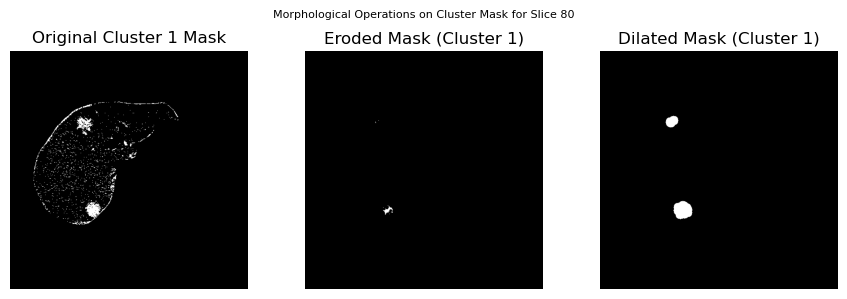

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 80:
Intersection over Union (IoU): 0.5167
Dice Coefficient: 0.6814


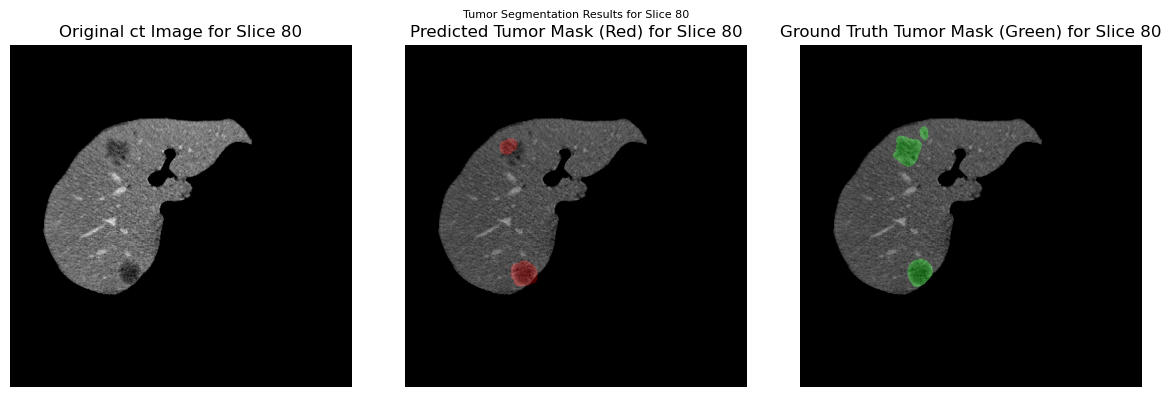

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 80:
Intersection over Union (IoU): 0.5275
Dice Coefficient: 0.6907


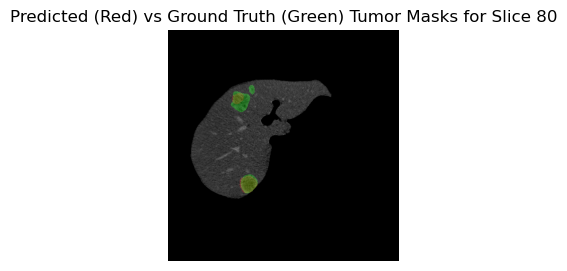


_________________________________________next_________________________________________



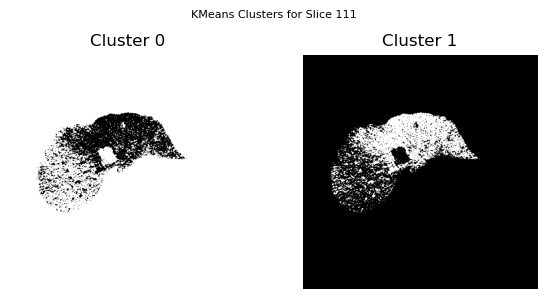

Evaluating silhouette scores for Slice 111:
k: 2  , Silhouette Score: 0.532
k: 3  , Silhouette Score: 0.529
k: 4  , Silhouette Score: 0.519
k: 5  , Silhouette Score: 0.515
k: 6  , Silhouette Score: 0.522
k: 7  , Silhouette Score: 0.519
k: 8  , Silhouette Score: 0.520
k: 9  , Silhouette Score: 0.522


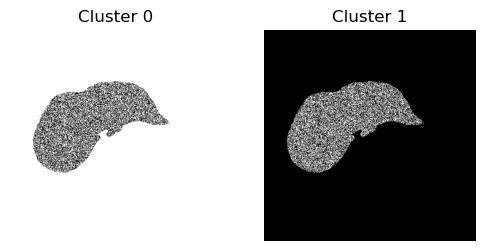

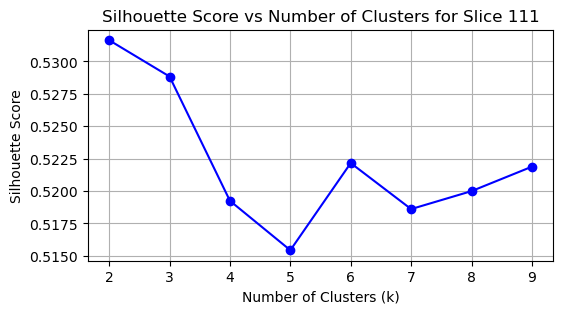

Best number of Clusters (K) for Slice 111 based on silhouette score: 2
Best silhouette score for Slice 111: 0.532
Cluster 1 for Slice 111 has the minimum number of pixels: 19606


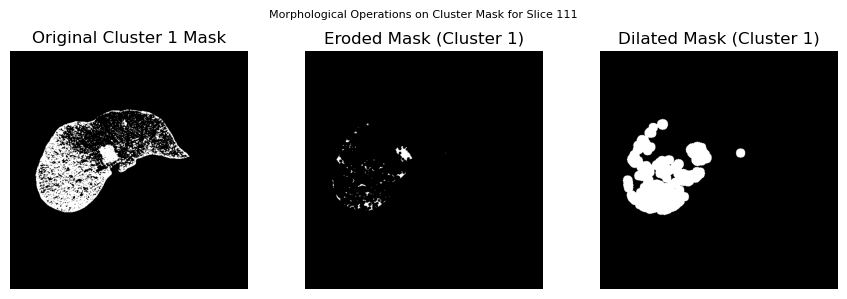

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 111:
Intersection over Union (IoU): 0.0802
Dice Coefficient: 0.1486


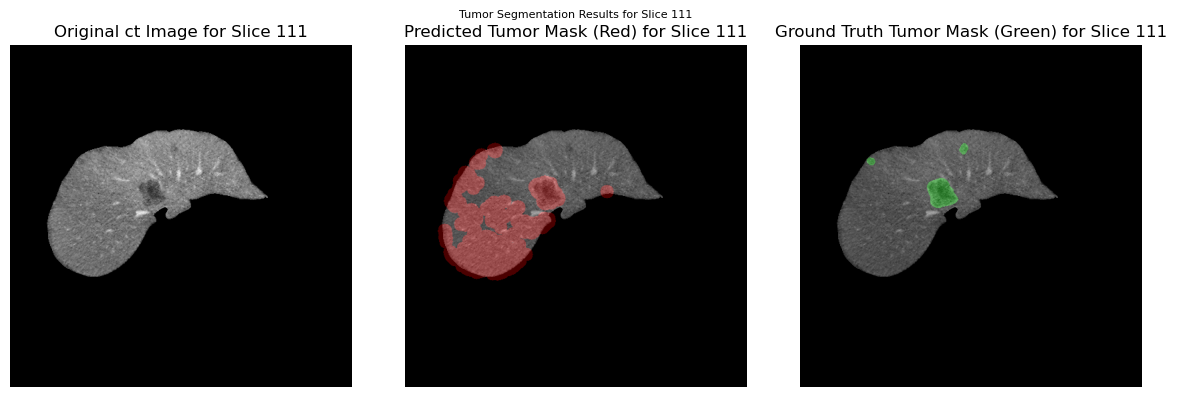

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 111:
Intersection over Union (IoU): 0.0904
Dice Coefficient: 0.1658


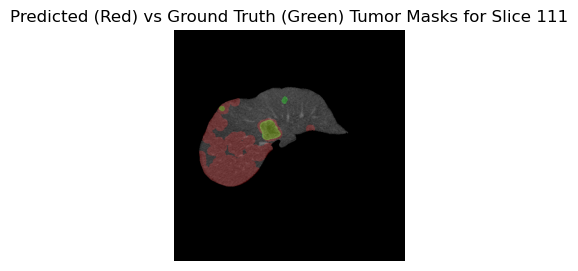


_________________________________________next_________________________________________



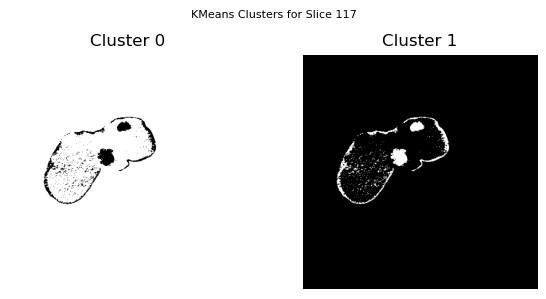

Evaluating silhouette scores for Slice 117:
k: 2  , Silhouette Score: 0.599
k: 3  , Silhouette Score: 0.536
k: 4  , Silhouette Score: 0.504
k: 5  , Silhouette Score: 0.533
k: 6  , Silhouette Score: 0.520
k: 7  , Silhouette Score: 0.520
k: 8  , Silhouette Score: 0.523
k: 9  , Silhouette Score: 0.518


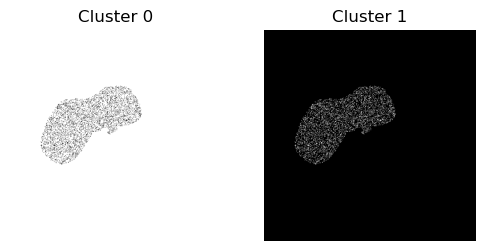

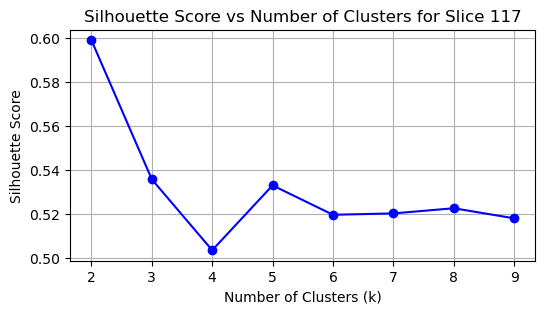

Best number of Clusters (K) for Slice 117 based on silhouette score: 2
Best silhouette score for Slice 117: 0.599
Cluster 1 for Slice 117 has the minimum number of pixels: 4737


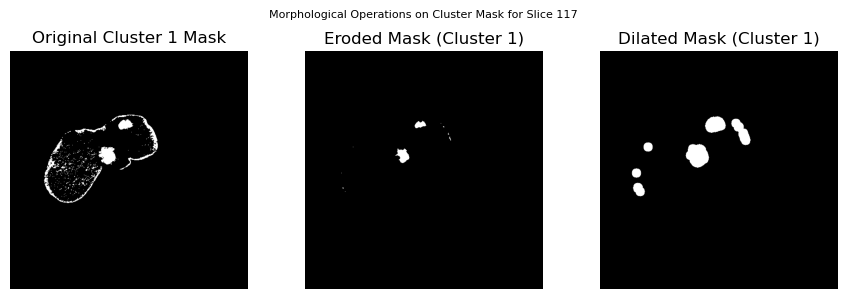

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 117:
Intersection over Union (IoU): 0.4159
Dice Coefficient: 0.5875


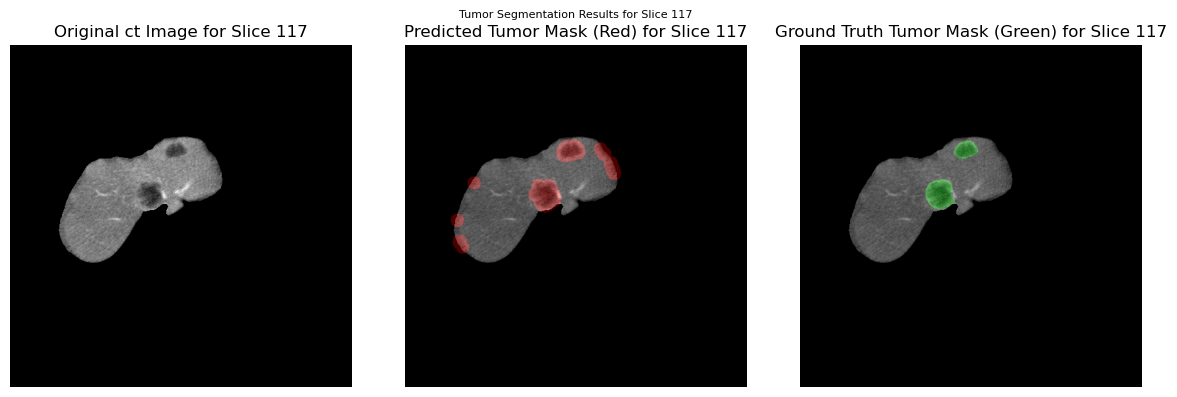

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 117:
Intersection over Union (IoU): 0.4917
Dice Coefficient: 0.6593


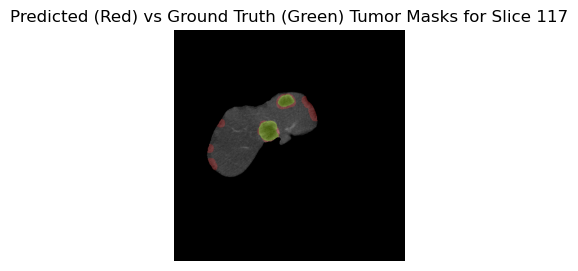


_________________________________________next_________________________________________



In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle
from skimage.morphology import erosion, dilation, disk
from sklearn.metrics import jaccard_score, f1_score

slices = [60, 80, 111, 117]

for slice_index in slices:
    ct_slice = ct_volume[slice_index, :, :]
    liver_mask_slice = liver_mask_volume[slice_index, :, :]
    tumor_mask_slice = tumors_mask_volume[slice_index, :, :]
    
    liver_extracted_ct_slice = ct_slice * liver_mask_slice

    liver_pixels_slice = liver_extracted_ct_slice[liver_mask_slice > 0]
    liver_pixels_slice = liver_pixels_slice.reshape(-1, 1)

    scaler = StandardScaler()
    liver_pixels_scaled_slice = scaler.fit_transform(liver_pixels_slice)

    k = 2
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(liver_pixels_scaled_slice)
    labels = kmeans.predict(liver_pixels_scaled_slice)

    clustered_image = np.zeros(liver_extracted_ct_slice.shape, dtype=int)
    clustered_image[liver_mask_slice > 0] = labels
    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    plt.figure(figsize=(6, 3))
    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i + 1)
        mask = clustered_image == i
        plt.imshow(mask, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')

    plt.suptitle(f'KMeans Clusters for Slice {slice_index}', fontsize=8)
    plt.tight_layout()
    plt.show()

    sample_size = 50000
    n_pixels = liver_pixels_scaled_slice.shape[0]
    indices = shuffle(np.arange(n_pixels), random_state=42)[:sample_size]
    pixels_sample = liver_pixels_scaled_slice[indices]

    silhouette_scores = []
    best_score = -1
    best_k = None
    best_kmeans = None

    print(f"Evaluating silhouette scores for Slice {slice_index}:")
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(pixels_sample)
        sample_labels = kmeans.predict(pixels_sample)
        score = silhouette_score(pixels_sample, sample_labels)
        silhouette_scores.append(score)
        print(f"k: {k:<2} , Silhouette Score: {score:.3f}")

        if score > best_score:
            best_score = score
            best_k = k
            best_kmeans = kmeans

    labels = best_kmeans.labels_
    clustered_image = np.zeros(liver_extracted_ct_slice.shape, dtype=int)
    clustered_image[liver_mask_slice > 0] = labels

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    plt.figure(figsize=(6, 3))
    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i + 1)
        mask = clustered_image == i
        plt.imshow(mask, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')

    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(2, 10), silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs Number of Clusters for Slice {slice_index}')
    plt.grid()
    plt.show()

    print(f"Best number of Clusters (K) for Slice {slice_index} based on silhouette score: {best_k}")
    print(f"Best silhouette score for Slice {slice_index}: {best_score:.3f}")
    labels = best_kmeans.predict(liver_pixels_scaled_slice)

    clustered_image = np.zeros(liver_extracted_ct_slice.shape, dtype=int)
    clustered_image[liver_mask_slice > 0] = labels

    pixel_counts = np.bincount(labels)
    min_cluster_id = np.argmin(pixel_counts)
    min_cluster_count = pixel_counts[min_cluster_id]

    print(f"Cluster {min_cluster_id} for Slice {slice_index} has the minimum number of pixels: {min_cluster_count}")
    min_cluster_mask = (clustered_image == min_cluster_id)

    structuring_element = disk(3)
    eroded_mask = erosion(min_cluster_mask, structuring_element)
    structuring_element = disk(10)
    dilated_mask = dilation(eroded_mask, structuring_element)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(min_cluster_mask, cmap='gray')
    axes[0].set_title(f'Original Cluster {min_cluster_id} Mask')
    axes[0].axis('off')
    axes[1].imshow(eroded_mask, cmap='gray')
    axes[1].set_title(f'Eroded Mask (Cluster {min_cluster_id})')
    axes[1].axis('off')
    axes[2].imshow(dilated_mask, cmap='gray')
    axes[2].set_title(f'Dilated Mask (Cluster {min_cluster_id})')
    axes[2].axis('off')
    plt.suptitle(f'Morphological Operations on Cluster Mask for Slice {slice_index}', fontsize=8)
    plt.tight_layout()
    plt.show()

    predicted_flat = dilated_mask.flatten()
    ground_truth_flat = tumor_mask_slice.flatten()

    iou = jaccard_score(ground_truth_flat, predicted_flat)
    dice = f1_score(ground_truth_flat, predicted_flat)

    print(f"\nEvaluation Metrics for Tumor Segmentation for Slice {slice_index}:")
    print(f"Intersection over Union (IoU): {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    ct_rgb = np.stack([liver_extracted_ct_slice] * 3, axis=-1)
    predicted_overlay = np.zeros_like(ct_rgb)
    ground_truth_overlay = np.zeros_like(ct_rgb)

    predicted_overlay[dilated_mask == 1] = [255, 0, 0]
    ground_truth_overlay[tumor_mask_slice == 1] = [0, 255, 0]

    combined_overlay = ct_rgb.copy()
    combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
    combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.title(f'Original ct Image for Slice {slice_index}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(predicted_overlay, alpha=0.3)
    plt.title(f'Predicted Tumor Mask (Red) for Slice {slice_index}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(ground_truth_overlay, alpha=0.3)
    plt.title(f'Ground Truth Tumor Mask (Green) for Slice {slice_index}')
    plt.axis('off')

    plt.suptitle(f'Tumor Segmentation Results for Slice {slice_index}', fontsize=8)
    plt.tight_layout()
    plt.show()

    predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask_slice)
    predicted_overlay = np.zeros_like(ct_rgb)
    predicted_overlay[predicted_tumor_mask == 1] = [255, 0, 0]
    combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)

    predicted_flat = predicted_tumor_mask.flatten()
    ground_truth_flat = tumor_mask_slice.flatten()

    iou = jaccard_score(ground_truth_flat, predicted_flat)
    dice = f1_score(ground_truth_flat, predicted_flat)

    print(f"\nEvaluation Metrics for Tumor Segmentation for Slice {slice_index}:")
    print(f"Intersection over Union (IoU): {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    plt.figure(figsize=(3, 3))
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(predicted_overlay, alpha=0.3)
    plt.imshow(ground_truth_overlay, alpha=0.3)
    plt.title(f'Predicted (Red) vs Ground Truth (Green) Tumor Masks for Slice {slice_index}')
    plt.axis('off')
    plt.show()

    print("\n_________________________________________next_________________________________________\n")

## Exercise 2: Implement MiniBatchKMeans
Implement the MiniBatchKMeans algorithm for the following slices: **60**, **80**, **111**, and **117**. Compare the results with KMeans on the same slices to understand the differences in performance and computational efficiency.


Evaluating and plotting clusters and silhouette diagrams for Slice 60:


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


2 , Silhouette Score: 0.621


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


3 , Silhouette Score: 0.544


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


4 , Silhouette Score: 0.527


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


5 , Silhouette Score: 0.511


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


6 , Silhouette Score: 0.514


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


7 , Silhouette Score: 0.513


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


8 , Silhouette Score: 0.512


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


9 , Silhouette Score: 0.488


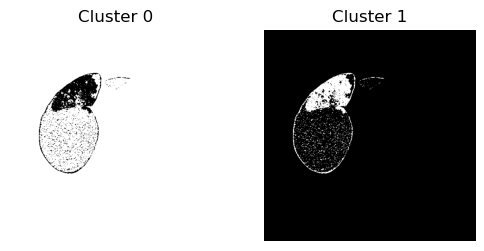

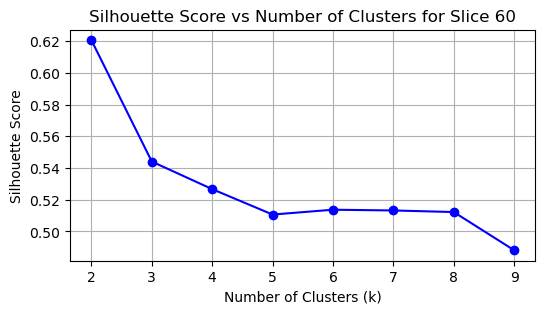

Best number of Clusters (K) for Slice 60 based on silhouette score: 2
Best silhouette score for Slice 60: 0.621
Cluster 1 for Slice 60 has the minimum number of pixels: 8117


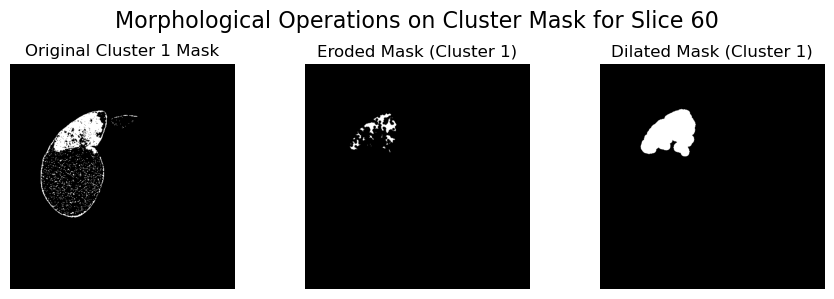

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 60:
Intersection over Union (IoU): 0.7756
Dice Coefficient: 0.8736


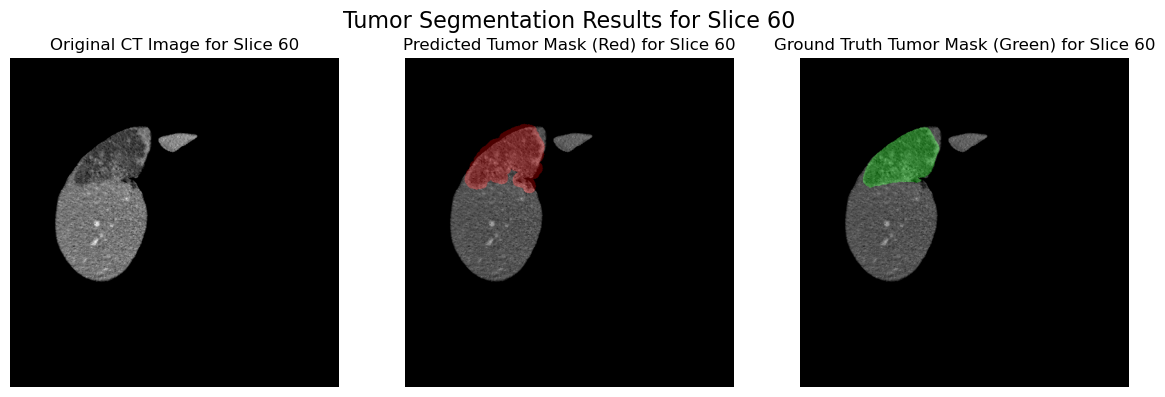

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 60:
Intersection over Union (IoU): 0.8733
Dice Coefficient: 0.9324


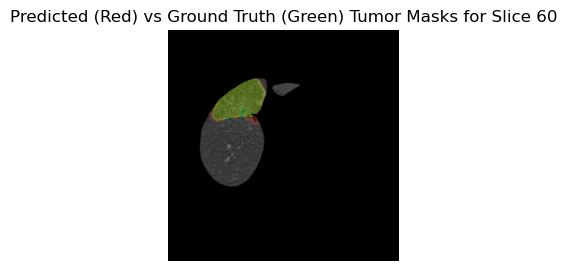


_________________________________________next_________________________________________

Evaluating and plotting clusters and silhouette diagrams for Slice 80:


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


2 , Silhouette Score: 0.520


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


3 , Silhouette Score: 0.515


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


4 , Silhouette Score: 0.513


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


5 , Silhouette Score: 0.519


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


6 , Silhouette Score: 0.516


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


7 , Silhouette Score: 0.515


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


8 , Silhouette Score: 0.520


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


9 , Silhouette Score: 0.520


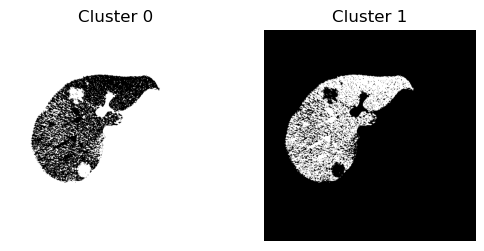

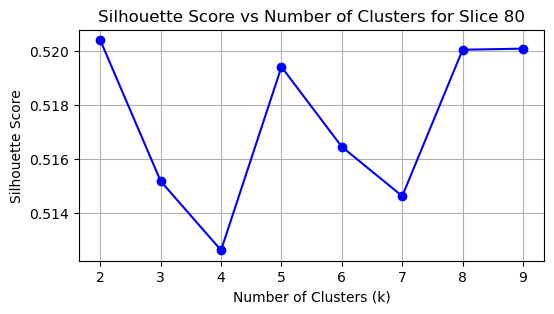

Best number of Clusters (K) for Slice 80 based on silhouette score: 2
Best silhouette score for Slice 80: 0.520
Cluster 0 for Slice 80 has the minimum number of pixels: 13271


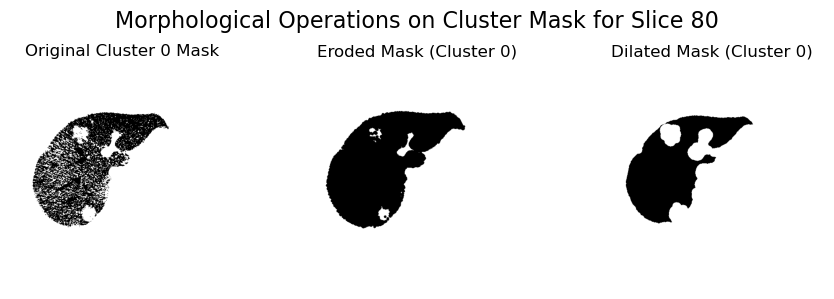

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 80:
Intersection over Union (IoU): 0.0112
Dice Coefficient: 0.0222


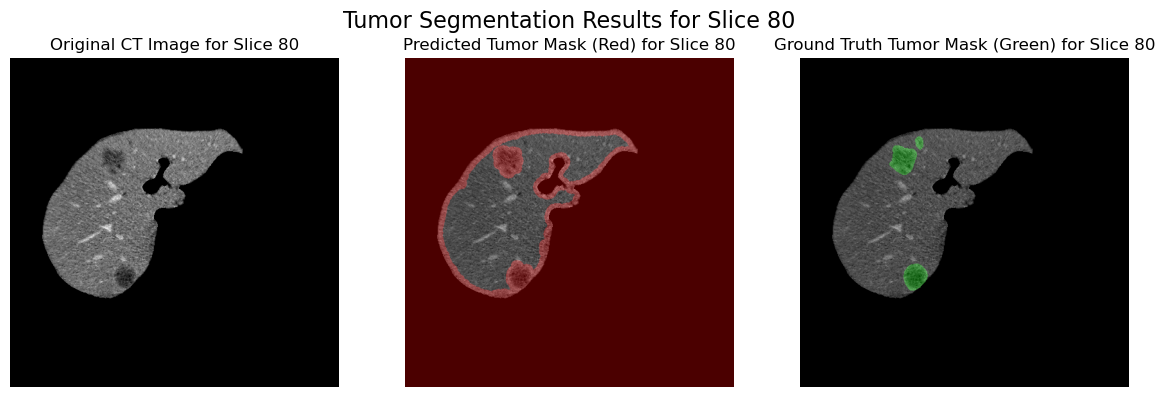

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 80:
Intersection over Union (IoU): 0.1921
Dice Coefficient: 0.3223


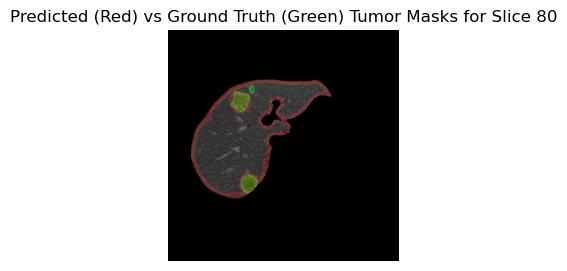


_________________________________________next_________________________________________

Evaluating and plotting clusters and silhouette diagrams for Slice 111:


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


2 , Silhouette Score: 0.529


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


3 , Silhouette Score: 0.502


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


4 , Silhouette Score: 0.511


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


5 , Silhouette Score: 0.514


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


6 , Silhouette Score: 0.520


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


7 , Silhouette Score: 0.519


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


8 , Silhouette Score: 0.518


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


9 , Silhouette Score: 0.522


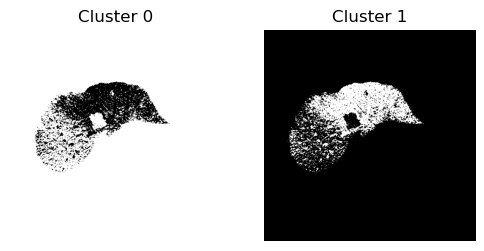

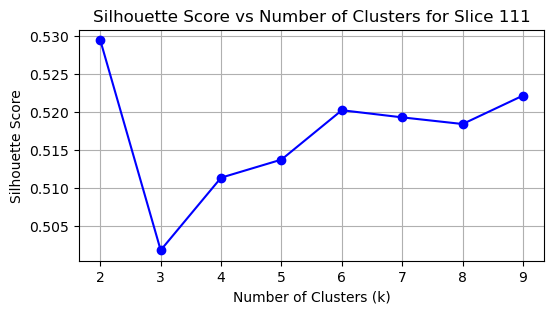

Best number of Clusters (K) for Slice 111 based on silhouette score: 2
Best silhouette score for Slice 111: 0.529
Cluster 0 for Slice 111 has the minimum number of pixels: 18792


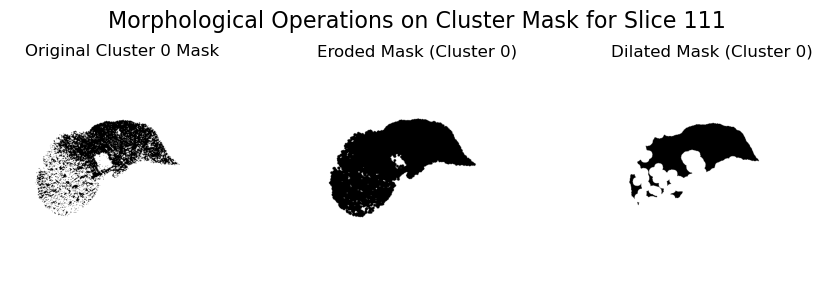

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 111:
Intersection over Union (IoU): 0.0065
Dice Coefficient: 0.0129


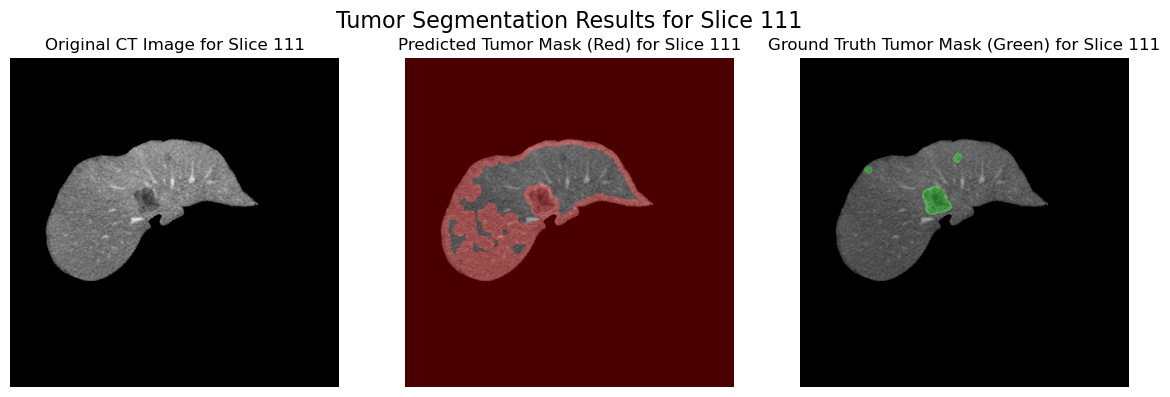

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 111:
Intersection over Union (IoU): 0.0752
Dice Coefficient: 0.1399


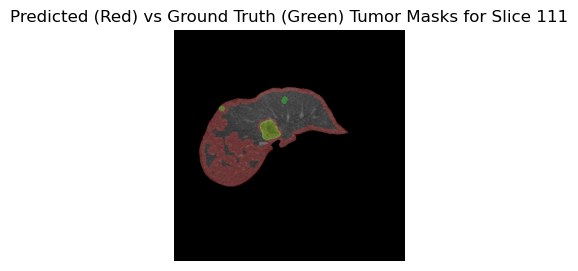


_________________________________________next_________________________________________

Evaluating and plotting clusters and silhouette diagrams for Slice 117:


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


2 , Silhouette Score: 0.506


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


3 , Silhouette Score: 0.534


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


4 , Silhouette Score: 0.528


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


5 , Silhouette Score: 0.497


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


6 , Silhouette Score: 0.502


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


7 , Silhouette Score: 0.504


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


8 , Silhouette Score: 0.517


d:\apps\Anaconda_ins\installation\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3584 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


9 , Silhouette Score: 0.511


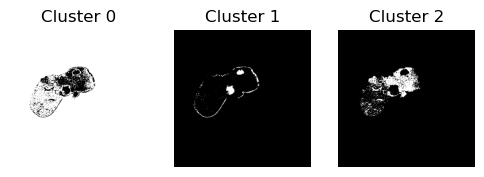

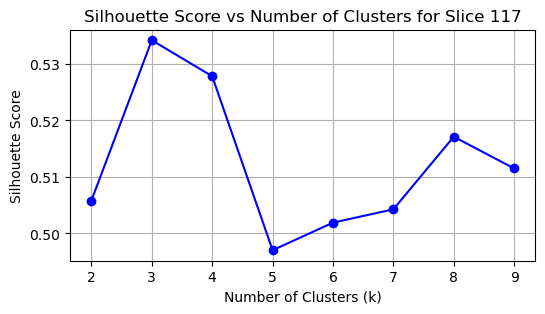

Best number of Clusters (K) for Slice 117 based on silhouette score: 3
Best silhouette score for Slice 117: 0.534
Cluster 1 for Slice 117 has the minimum number of pixels: 2296


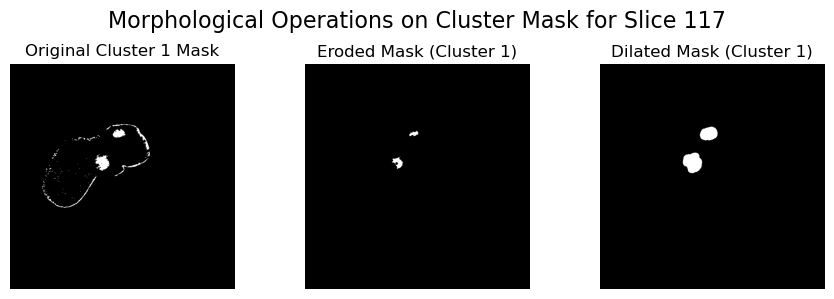

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 117:
Intersection over Union (IoU): 0.8042
Dice Coefficient: 0.8915


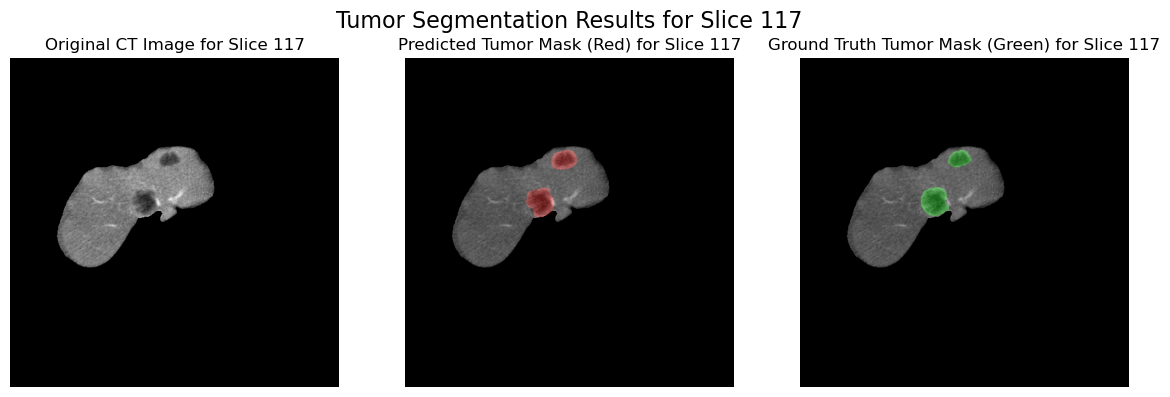

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



Evaluation Metrics for Tumor Segmentation for Slice 117:
Intersection over Union (IoU): 0.8103
Dice Coefficient: 0.8952


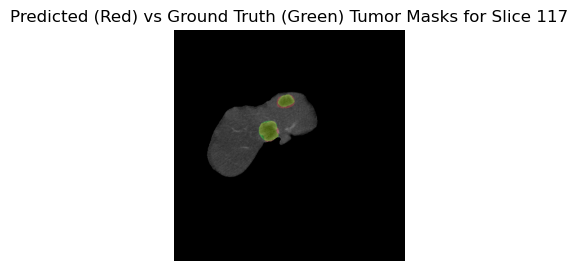


_________________________________________next_________________________________________



In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.morphology import erosion, dilation, disk
from sklearn.metrics import jaccard_score, f1_score

slices = [60, 80, 111, 117]

for slice_index in slices:
    ct_slice = ct_volume[slice_index, :, :]
    liver_mask_slice = liver_mask_volume[slice_index, :, :]
    tumor_mask_slice = tumors_mask_volume[slice_index, :, :]

    liver_extracted_ct_slice = ct_slice * liver_mask_slice

    liver_pixels_slice = liver_extracted_ct_slice[liver_mask_slice > 0]
    liver_pixels_slice = liver_pixels_slice.reshape(-1, 1)

    scaler = StandardScaler()
    liver_pixels_scaled_slice = scaler.fit_transform(liver_pixels_slice)

    sample_size = 50000
    n_pixels = liver_pixels_scaled_slice.shape[0]
    indices = shuffle(np.arange(n_pixels), random_state=42)[:sample_size]
    pixels_sample = liver_pixels_scaled_slice[indices]

    silhouette_scores = []
    best_score = -1
    best_k = None
    best_kmeans = None

    print(f"Evaluating and plotting clusters and silhouette diagrams for Slice {slice_index}:")

    for k in range(2, 10):
        minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=100, random_state=42)
        minibatch_kmeans.fit(pixels_sample)

        sample_labels = minibatch_kmeans.predict(pixels_sample)
        score = silhouette_score(pixels_sample, sample_labels)
        silhouette_scores.append(score)

        print(f"{k:<2}, Silhouette Score: {score:.3f}")

        if score > best_score:
            best_score = score
            best_k = k
            best_kmeans = minibatch_kmeans

    labels = best_kmeans.predict(liver_pixels_scaled_slice)

    clustered_image = np.zeros(liver_extracted_ct_slice.shape, dtype=int)
    clustered_image[liver_mask_slice > 0] = labels

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    plt.figure(figsize=(6, 3))
    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i + 1)
        mask = clustered_image == i
        plt.imshow(mask, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')

    plt.figure(figsize=(6, 3))
    plt.plot(np.arange(2, 10), silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs Number of Clusters for Slice {slice_index}')
    plt.grid()
    plt.show()

    print(f"Best number of Clusters (K) for Slice {slice_index} based on silhouette score: {best_k}")
    print(f"Best silhouette score for Slice {slice_index}: {best_score:.3f}")

    labels = best_kmeans.predict(liver_pixels_scaled_slice)
    clustered_image = np.zeros(liver_extracted_ct_slice.shape, dtype=int)
    clustered_image[liver_mask_slice > 0] = labels

    pixel_counts = np.bincount(labels)
    min_cluster_id = np.argmin(pixel_counts)
    min_cluster_count = pixel_counts[min_cluster_id]

    print(f"Cluster {min_cluster_id} for Slice {slice_index} has the minimum number of pixels: {min_cluster_count}")
    min_cluster_mask = (clustered_image == min_cluster_id)

    structuring_element = disk(3)
    eroded_mask = erosion(min_cluster_mask, structuring_element)
    structuring_element = disk(10)
    dilated_mask = dilation(eroded_mask, structuring_element)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(min_cluster_mask, cmap='gray')
    axes[0].set_title(f'Original Cluster {min_cluster_id} Mask')
    axes[0].axis('off')
    axes[1].imshow(eroded_mask, cmap='gray')
    axes[1].set_title(f'Eroded Mask (Cluster {min_cluster_id})')
    axes[1].axis('off')
    axes[2].imshow(dilated_mask, cmap='gray')
    axes[2].set_title(f'Dilated Mask (Cluster {min_cluster_id})')
    axes[2].axis('off')
    plt.suptitle(f'Morphological Operations on Cluster Mask for Slice {slice_index}', fontsize=16)
    plt.tight_layout()
    plt.show()

    predicted_flat = dilated_mask.flatten()
    ground_truth_flat = tumor_mask_slice.flatten()

    iou = jaccard_score(ground_truth_flat, predicted_flat)
    dice = f1_score(ground_truth_flat, predicted_flat)

    print(f"\nEvaluation Metrics for Tumor Segmentation for Slice {slice_index}:")
    print(f"Intersection over Union (IoU): {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    ct_rgb = np.stack([liver_extracted_ct_slice] * 3, axis=-1)
    predicted_overlay = np.zeros_like(ct_rgb)
    ground_truth_overlay = np.zeros_like(ct_rgb)

    predicted_overlay[dilated_mask == 1] = [255, 0, 0]
    ground_truth_overlay[tumor_mask_slice == 1] = [0, 255, 0]

    combined_overlay = ct_rgb.copy()
    combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
    combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.title(f'Original CT Image for Slice {slice_index}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(predicted_overlay, alpha=0.3)
    plt.title(f'Predicted Tumor Mask (Red) for Slice {slice_index}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(ground_truth_overlay, alpha=0.3)
    plt.title(f'Ground Truth Tumor Mask (Green) for Slice {slice_index}')
    plt.axis('off')

    plt.suptitle(f'Tumor Segmentation Results for Slice {slice_index}', fontsize=16)
    plt.tight_layout()
    plt.show()

    predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask_slice)
    predicted_overlay = np.zeros_like(ct_rgb)
    predicted_overlay[predicted_tumor_mask == 1] = [255, 0, 0]
    combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)

    predicted_flat = predicted_tumor_mask.flatten()
    ground_truth_flat = tumor_mask_slice.flatten()

    iou = jaccard_score(ground_truth_flat, predicted_flat)
    dice = f1_score(ground_truth_flat, predicted_flat)

    print(f"\nEvaluation Metrics for Tumor Segmentation for Slice {slice_index}:")
    print(f"Intersection over Union (IoU): {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    plt.figure(figsize=(3, 3))
    plt.imshow(liver_extracted_ct_slice, cmap='gray')
    plt.imshow(predicted_overlay, alpha=0.3)
    plt.imshow(ground_truth_overlay, alpha=0.3)
    plt.title(f'Predicted (Red) vs Ground Truth (Green) Tumor Masks for Slice {slice_index}')
    plt.axis('off')
    plt.show()

    print("\n_________________________________________next_________________________________________\n")

## Exercise 3: Optimize DBScan with Grid Search
Using grid search, find the best `min_samples` parameter for DBScan in the range **400** to **1400**, with `eps` set at **0.07**. Use slice 80 from the 3Dircadb dataset for this exercise.

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import jaccard_score, f1_score
from skimage.morphology import erosion, dilation, disk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



best_iou,best_dice = -1, -1
best_min_samples = None

min_samples_range = range(400, 1401, 100)


ct = ct_volume[80, :, :]
liver_mask = liver_mask_volume[80, :, :]
tumor_mask = tumors_mask_volume[80, :, :]
liver_extracted_ct = ct * liver_mask

liver_pixels = liver_extracted_ct[liver_mask > 0]
liver_pixels = liver_pixels.reshape(-1, 1)

scaler = StandardScaler()
liver_pixels_scaled = scaler.fit_transform(liver_pixels)




for min_samples in min_samples_range:
    
    dbscan = DBSCAN(eps=0.07, min_samples=min_samples, metric="l2")
    labels = dbscan.fit_predict(liver_pixels_scaled)

    db_cluster_image = np.zeros(liver_extracted_ct.shape, dtype=int)
    db_cluster_image[liver_mask > 0] = labels

    selected_cluster_mask = (db_cluster_image == -1)

    structuring_element = disk(3)
    eroded_mask = erosion(selected_cluster_mask, structuring_element)
    structuring_element = disk(10)
    dilated_mask = dilation(eroded_mask, structuring_element)

    predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask)

    predicted_flat = predicted_tumor_mask.flatten()
    ground_truth_flat = tumor_mask.flatten()

    iou = jaccard_score(ground_truth_flat, predicted_flat)
    dice = f1_score(ground_truth_flat, predicted_flat)

    print(f"min_samples={min_samples}, IoU={iou:.4f}, Dice={dice:.4f}")

    if iou > best_iou or (iou == best_iou and dice > best_dice):
        best_iou = iou
        best_dice = dice
        best_min_samples = min_samples

print("\n__________________________________________________________________________________\n")
print("Best Parameters:")
print(f"min_samples={best_min_samples}, Best IoU={best_iou:.4f}, Best Dice={best_dice:.4f}")




min_samples=400, IoU=0.1950, Dice=0.3264
min_samples=500, IoU=0.2226, Dice=0.3641
min_samples=600, IoU=0.4104, Dice=0.5819
min_samples=700, IoU=0.4134, Dice=0.5850
min_samples=800, IoU=0.4114, Dice=0.5829
min_samples=900, IoU=0.4532, Dice=0.6237
min_samples=1000, IoU=0.4077, Dice=0.5793
min_samples=1100, IoU=0.4050, Dice=0.5765
min_samples=1200, IoU=0.4079, Dice=0.5794
min_samples=1300, IoU=0.3889, Dice=0.5600
min_samples=1400, IoU=0.3897, Dice=0.5608

__________________________________________________________________________________

Best Parameters:
min_samples=900, Best IoU=0.4532, Best Dice=0.6237


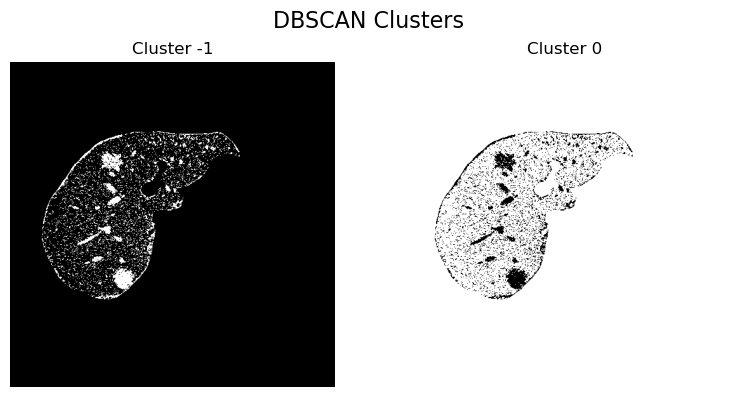

In [18]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.07, min_samples=900, metric="l2")
labels = dbscan.fit_predict(liver_pixels_scaled)

db_cluster_image = np.zeros(liver_extracted_ct.shape, dtype=int)
db_cluster_image[liver_mask > 0] = labels

unique_clusters = np.unique(labels)
num_clusters = len(unique_clusters)

plt.figure(figsize=(8, 4))
for i in range(num_clusters):
    mask = db_cluster_image == unique_clusters[i]
    plt.subplot(1, num_clusters, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cluster {unique_clusters[i]}')
    plt.axis('off')

plt.suptitle('DBSCAN Clusters', fontsize=16)
plt.tight_layout()
plt.show()

## Exercise 4: Determine Optimal GMM Components
Using both AIC and BIC criteria, find the best number of components for the Gaussian Mixture Model (GMM) on slice 117 of the 3Dircadb dataset. Discuss the implications of your findings on model selection.


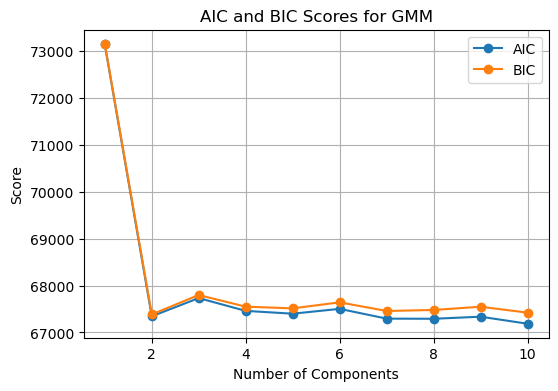

Best number of components based on AIC: 10
Best number of components based on BIC: 2


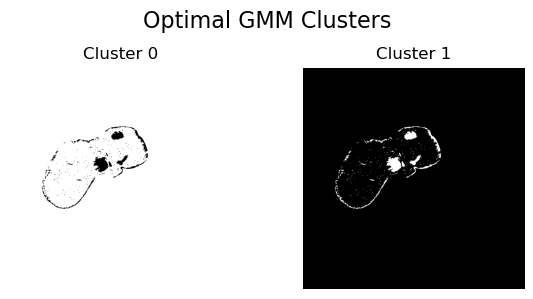

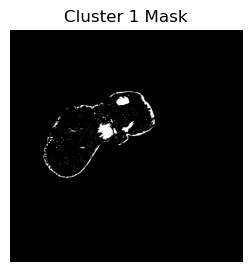

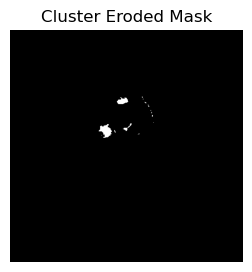

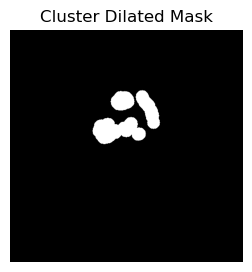

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


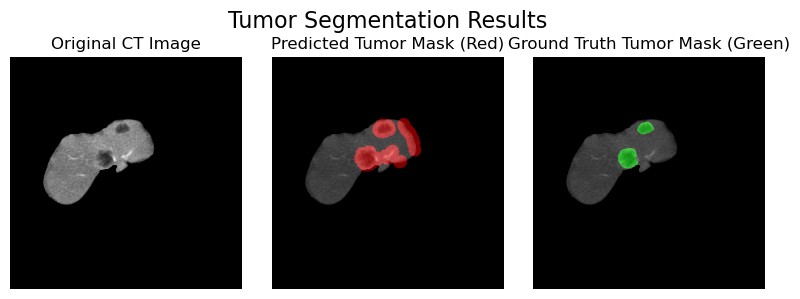

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


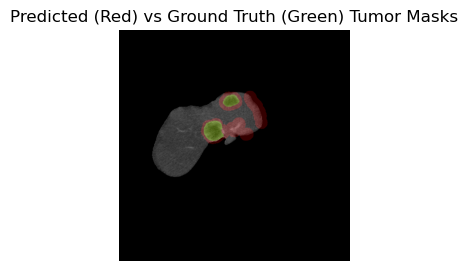

In [23]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

component_range = range(1, 11)

aic_scores = []
bic_scores = []

ct = ct_volume[117, :, :]
liver_mask = liver_mask_volume[117, :, :]
tumor_mask = tumors_mask_volume[117, :, :]
liver_extracted_ct117 = ct * liver_mask

liver_pixels = liver_extracted_ct117[liver_mask > 0]
liver_pixels = liver_pixels.reshape(-1, 1)

scaler = StandardScaler()
liver_pixels_scaled = scaler.fit_transform(liver_pixels)


for n_components in component_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(liver_pixels_scaled)  # Fit GMM to the data
    aic_scores.append(gmm.aic(liver_pixels_scaled))  # Append AIC
    bic_scores.append(gmm.bic(liver_pixels_scaled))  # Append BIC

plt.figure(figsize=(6, 4))
plt.plot(component_range, aic_scores, label='AIC', marker='o')
plt.plot(component_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for GMM')
plt.legend()
plt.grid()
plt.show()

best_n_components_aic = component_range[np.argmin(aic_scores)]
best_n_components_bic = component_range[np.argmin(bic_scores)]

print(f"Best number of components based on AIC: {best_n_components_aic}")
print(f"Best number of components based on BIC: {best_n_components_bic}")

gmm = GaussianMixture(n_components=best_n_components_bic, random_state=42)
gmm.fit(liver_pixels_scaled)

labels = gmm.predict(liver_pixels_scaled)

gmm_cluster_image = np.zeros(liver_extracted_ct117.shape, dtype=int)
gmm_cluster_image[liver_mask > 0] = labels

unique_clusters = np.unique(labels)
num_clusters = len(unique_clusters)

plt.figure(figsize=(6, 3))
for i in range(num_clusters):
    plt.subplot(1, num_clusters, i + 1)
    mask = gmm_cluster_image == unique_clusters[i]
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cluster {unique_clusters[i]}')
    plt.axis('off')

plt.suptitle('Optimal GMM Clusters', fontsize=16)
plt.tight_layout()
plt.show()

selected_cluster_mask = (gmm_cluster_image == 1)

plt.figure(figsize=(3, 7))
plt.imshow(selected_cluster_mask, cmap="gray")
plt.title(f'Cluster 1 Mask')
plt.axis('off')
plt.show()

from skimage.morphology import square, disk, erosion, dilation

structuring_element = square(4)
eroded_mask = erosion(selected_cluster_mask, structuring_element)

plt.figure(figsize=(3,7))
plt.imshow(eroded_mask, cmap='gray')
plt.title(f'Cluster Eroded Mask')
plt.axis('off')
plt.show()

structuring_element = disk(14)
dilated_mask = dilation(eroded_mask, structuring_element)

plt.figure(figsize=(3, 7))
plt.imshow(dilated_mask, cmap='gray')
plt.title(f'Cluster Dilated Mask')
plt.axis('off')
plt.show()

ct_rgb = np.stack([liver_extracted_ct117] * 3, axis=-1)

predicted_overlay = np.zeros_like(ct_rgb)
ground_truth_overlay = np.zeros_like(ct_rgb)

predicted_overlay[dilated_mask == 1] = [255, 0, 0] 
ground_truth_overlay[tumor_mask == 1] = [0, 255, 0]  

combined_overlay = ct_rgb.copy()
combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plt.imshow(liver_extracted_ct117, cmap='gray')
plt.title('Original CT Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(liver_extracted_ct117, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.5) 
plt.title('Predicted Tumor Mask (Red)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(liver_extracted_ct117, cmap='gray')
plt.imshow(ground_truth_overlay, alpha=0.5)  
plt.title('Ground Truth Tumor Mask (Green)')
plt.axis('off')

plt.suptitle('Tumor Segmentation Results', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(liver_extracted_ct117, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.3)  
plt.imshow(ground_truth_overlay, alpha=0.3)  
plt.title('Predicted (Red) vs Ground Truth (Green) Tumor Masks')
plt.axis('off')
plt.show()
